In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

# Image Preparation

In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'SaltID/train/'
path_test = 'SaltID/test/'

In [4]:
train_path_images = os.path.abspath("SaltID/train/images")
train_path_masks = os.path.abspath("SaltID/train/masks")

test_path_images = os.path.abspath("SaltID/test/images")
test_path_masks = os.path.abspath("SaltID/test/masks")

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID\\test\\images'

In [5]:
train_path_images_list = glob(os.path.join(train_path_images, "**/*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "**/*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "**/*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "**/*.png"))

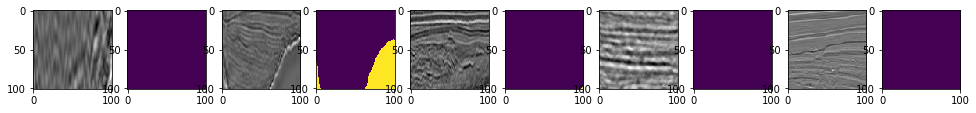

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread('SaltID/train/images/' + img_name + '.png')
    img_mask = imread('SaltID/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [8]:
depths = pd.read_csv("SaltID/depths.csv")
print(depths['z'].min(), depths['z'].max())

50 959


In [134]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='edge', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='edge', 
                        anti_aliasing=True,
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [10]:
# # Get and resize train images and masks
# X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
# print('Getting and resizing test images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
#     img = imread(path_test + '/images/' + id_)
#     x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
#     X_test[n] = x

# print('Done!')

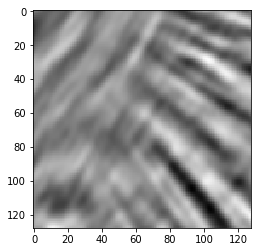

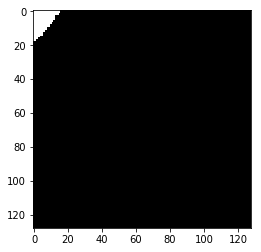

In [135]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [136]:
# # Check if training data looks all right
# ix = random.randint(0, len(test_ids))
# plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
# plt.show()

# Prepare Images for Pytorch

In [137]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [138]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [140]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

#X_test_shaped = X_test.astype(np.float32)

In [141]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [196]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/2
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]

In [197]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped)
salt_ID_dataset_val = saltIDDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped)
#salt_ID_dataset_test = saltIDDataset(X_test_shaped, train=False)

batch_size = 32
n_iters = 8000
num_epochs = n_iters / (len(X_train_shaped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

# test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
#                                           batch_size=batch_size, 
#                                           shuffle=False)

In [198]:
num_epochs

64

# Define U-Net Model

In [204]:
def conv_relu(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 8

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1 (?)
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        #print(conv1.size(), maxpool1.size())

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        #print(conv2.size(), maxpool2.size())

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        #print(conv3.size(), maxpool3.size())

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        #print(conv4.size(), maxpool4.size())
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        #print(conv5.size())
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        #print(cat4.size())
        ex_conv4 = self.ex_double_conv4(cat4)
        #print(t_conv4.size(), ex_conv4.size())
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        #print(t_conv3.size(), ex_conv3.size())

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        #print(t_conv2.size(), ex_conv2.size())
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        #print(t_conv1.size(), ex_conv1.size())
        
        one_by_one = self.one_by_one(ex_conv1)
        #print(one_by_one.size())
        final = self.final_act(one_by_one)
        
        #final = torch.where((final > .5).cuda(), ones, zeros)
        
        return final

In [205]:
model = Unet()
model.cuda();

criterion = nn.BCELoss()

learning_rate = 1e-2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [207]:
#output_dist = []
iter = 0
losses = []
for epoch in range(50):
    for i, (images, masks) in enumerate(train_loader):        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:

#             t_scores = []
#             # Iterate through test dataset
#             for threshold in [.1]: #, .55, .6, .65, .7, .75, .8, .85, .9, .95]:
#                 true_pos = 0
#                 false_pos = 0
#                 false_neg = 0
#                 true_neg = 0
#                 #print(threshold)
#                 for val_images, val_masks in train_loader:

#                     val_images = Variable(val_images.cuda())
#                     val_masks = val_masks.cuda()

#                     val_outputs = model(val_images)
#                     #print(val_outputs, val_outputs.shape)
#                     #if np.random.rand() > .99:
#                     #    output_dist.extend(val_outputs.cpu())
                    
#                     bin_outputs = torch.where(val_outputs > .3, 
#                                               ones, 
#                                               zeros).byte()
#                     #print(bin_outputs)
#                     bin_masks = val_masks.byte()
                    
#                     for bin_output, bin_mask in zip(bin_outputs, bin_masks):
#                         #print(bin_output | bin_mask)
#                         #print(bin_output & bin_mask)
#                         union = (bin_output | bin_mask).sum()
#                         inter = (bin_output & bin_mask).sum()
#                         #if inter > 0:
#                         #    print(union, inter)
#                         if inter == 0:
#                             iou = 0
#                         else:
#                             iou = inter / union
                        
#                         #print("iou", iou)
                        
#                         mask_obj = bin_mask.any()
#                         output_obj = bin_output.any()
                        
#                         #if output_obj:
#                         #    print(bin_output)
                        
#                         if iou > threshold:
#                             true_pos += 1
#                         elif iou <= threshold and mask_obj:
#                             false_neg += 1
#                         elif iou <= threshold and output_obj:
#                             false_pos += 1
#                         elif not mask_obj and not output_obj:
#                             true_neg += 1
#                         else:
#                             print("freak out")
                
#                 print(true_pos, false_pos, false_neg, true_neg)
#                 t_score = true_pos / (true_pos + false_pos + false_neg)
                    
#                 t_scores.append(t_score)

            # Print Loss
            t_scores=[1]
            losses.append(loss.data.item())
            print('Iteration: {}. Loss: {}. Mean IU: {}'.format(iter, loss.data.item(), np.mean(t_scores)))

Iteration: 100. Loss: 0.43310245871543884. Mean IU: 1.0
Iteration: 200. Loss: 0.46780019998550415. Mean IU: 1.0
Iteration: 300. Loss: 0.6498264670372009. Mean IU: 1.0
Iteration: 400. Loss: 0.5837527513504028. Mean IU: 1.0
Iteration: 500. Loss: 0.49686694145202637. Mean IU: 1.0
Iteration: 600. Loss: 0.5111945271492004. Mean IU: 1.0
Iteration: 700. Loss: 0.5762566924095154. Mean IU: 1.0
Iteration: 800. Loss: 0.5732434988021851. Mean IU: 1.0
Iteration: 900. Loss: 0.5741965770721436. Mean IU: 1.0
Iteration: 1000. Loss: 0.5381718873977661. Mean IU: 1.0
Iteration: 1100. Loss: 0.5121124982833862. Mean IU: 1.0
Iteration: 1200. Loss: 0.48439306020736694. Mean IU: 1.0
Iteration: 1300. Loss: 0.5866149663925171. Mean IU: 1.0
Iteration: 1400. Loss: 0.5434134006500244. Mean IU: 1.0
Iteration: 1500. Loss: 0.48069292306900024. Mean IU: 1.0
Iteration: 1600. Loss: 0.5081869959831238. Mean IU: 1.0
Iteration: 1700. Loss: 0.5326769948005676. Mean IU: 1.0
Iteration: 1800. Loss: 0.5620984435081482. Mean IU: 

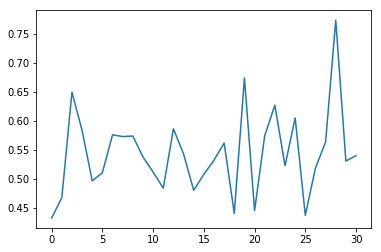

In [208]:
loss_series = pd.Series(losses)
loss_series.plot()

In [190]:
ones = torch.ones(batch_size, 1, 128, 128).cuda()
zeros = torch.zeros(batch_size, 1, 128, 128).cuda()

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        #print(diffX, diffY)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [129]:
# full assembly of the sub-parts to form the complete net

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 128)
        self.down4 = down(128, 256)
        self.up1 = up(256, 128)
        self.up2 = up(128, 64)
        self.up3 = up(64, 32)
        self.up4 = up(32, 16)
        self.outc = outconv(16, n_classes)

    def forward(self, x):
        #print("Start")
        #print(x.shape)
        x1 = self.inc(x)
        #print(x1.shape)
        x2 = self.down1(x1)
        #print(x2.shape)
        x3 = self.down2(x2)
        #print(x3.shape)
        x4 = self.down3(x3)
        #print(x4.shape)
        x5 = self.down4(x4)
        #print(x5.shape)
        x = self.up1(x5, x4)
        #print(x.shape)
        x = self.up2(x, x3)
        #print(x.shape)
        x = self.up3(x, x2)
        #print(x.shape)
        x = self.up4(x, x1)
        #print(x.shape)
        x = self.outc(x)
        #print(x.shape)
        return x

In [130]:
model = UNet(1, 1)
model.cuda();

criterion = nn.BCELoss()

learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [132]:
#output_dist = []
iter = 0
for epoch in range(30):
    for i, (images, masks) in enumerate(train_loader):        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        #print(F.sigmoid(outputs))
        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(F.sigmoid(outputs), masks)
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:

#             t_scores = []
#             # Iterate through test dataset
#             for threshold in [.1]: #, .55, .6, .65, .7, .75, .8, .85, .9, .95]:
#                 true_pos = 0
#                 false_pos = 0
#                 false_neg = 0
#                 true_neg = 0
#                 #print(threshold)
#                 for val_images, val_masks in train_loader:

#                     val_images = Variable(val_images.cuda())
#                     val_masks = val_masks.cuda()

#                     val_outputs = model(val_images)
#                     #print(val_outputs, val_outputs.shape)
#                     #if np.random.rand() > .99:
#                     #    output_dist.extend(val_outputs.cpu())
                    
#                     bin_outputs = torch.where(val_outputs > .3, 
#                                               ones, 
#                                               zeros).byte()
#                     #print(bin_outputs)
#                     bin_masks = val_masks.byte()
                    
#                     for bin_output, bin_mask in zip(bin_outputs, bin_masks):
#                         #print(bin_output | bin_mask)
#                         #print(bin_output & bin_mask)
#                         union = (bin_output | bin_mask).sum()
#                         inter = (bin_output & bin_mask).sum()
#                         #if inter > 0:
#                         #    print(union, inter)
#                         if inter == 0:
#                             iou = 0
#                         else:
#                             iou = inter / union
                        
#                         #print("iou", iou)
                        
#                         mask_obj = bin_mask.any()
#                         output_obj = bin_output.any()
                        
#                         #if output_obj:
#                         #    print(bin_output)
                        
#                         if iou > threshold:
#                             true_pos += 1
#                         elif iou <= threshold and mask_obj:
#                             false_neg += 1
#                         elif iou <= threshold and output_obj:
#                             false_pos += 1
#                         elif not mask_obj and not output_obj:
#                             true_neg += 1
#                         else:
#                             print("freak out")
                
#                 print(true_pos, false_pos, false_neg, true_neg)
#                 t_score = true_pos / (true_pos + false_pos + false_neg)
                    
#                 t_scores.append(t_score)

            # Print Loss
            t_scores=[1]
            print('Iteration: {}. Loss: {}. Mean IU: {}'.format(iter, loss.data.item(), np.mean(t_scores)))

Iteration: 100. Loss: 0.6310380697250366. Mean IU: 1.0
Iteration: 200. Loss: 0.6393115520477295. Mean IU: 1.0
Iteration: 300. Loss: 0.5855551362037659. Mean IU: 1.0
Iteration: 400. Loss: 0.6071594953536987. Mean IU: 1.0
Iteration: 500. Loss: 0.5921639800071716. Mean IU: 1.0
Iteration: 600. Loss: 0.5867204666137695. Mean IU: 1.0
Iteration: 700. Loss: 0.5815846920013428. Mean IU: 1.0
Iteration: 800. Loss: 0.6394532918930054. Mean IU: 1.0
Iteration: 900. Loss: 0.5399373769760132. Mean IU: 1.0
Iteration: 1000. Loss: 0.6075119376182556. Mean IU: 1.0
Iteration: 1100. Loss: 0.5282416939735413. Mean IU: 1.0
Iteration: 1200. Loss: 0.5855202674865723. Mean IU: 1.0
Iteration: 1300. Loss: 0.5737877488136292. Mean IU: 1.0
Iteration: 1400. Loss: 0.5793685913085938. Mean IU: 1.0
Iteration: 1500. Loss: 0.5928118228912354. Mean IU: 1.0
Iteration: 1600. Loss: 0.5757737159729004. Mean IU: 1.0
Iteration: 1700. Loss: 0.4487680494785309. Mean IU: 1.0
Iteration: 1800. Loss: 0.4978998303413391. Mean IU: 1.0
I

KeyboardInterrupt: 

In [221]:
def conv_relu(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

def double_conv(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

start_fm = 16

class Unet_simple(nn.Module):
    
    def __init__(self):
        super(Unet_simple, self).__init__()
        
        # Input 128x128x1 (?)
        
        #Contracting Path
        
        #(Double) Convolution 1        
        #self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        self.double_conv1a = nn.Conv2d(1, start_fm, 3,
                          1, 1)
        self.double_conv1b = nn.ReLU()
        self.double_conv1c = nn.Conv2d(start_fm, start_fm, 3,
                          1, 1)
        self.double_conv1d = nn.ReLU()
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
#         #Convolution 2
#         self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
#         #Max Pooling 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
#         #Convolution 3
#         self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
#         #Max Pooling 3
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
#         #Convolution 4
#         self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
#         #Max Pooling 4
#         self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        #self.double_conv5 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        self.double_conv5a = nn.Conv2d(start_fm, start_fm * 2, 3,
                          1, 1)
        self.double_conv5b = nn.ReLU()
        self.double_conv5c = nn.Conv2d(start_fm * 2, start_fm * 2, 3,
                          1, 1)
        self.double_conv5d = nn.ReLU() 
        
#         #Transposed Convolution 4
#         self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
#         # Expanding Path Convolution 4 
#         self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
#         #Transposed Convolution 3
#         self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
#         #Convolution 3
#         self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
#         #Transposed Convolution 2
#         self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
#         #Convolution 2
#         self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        #self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        self.ex_double_conv1a = nn.Conv2d(start_fm * 2, start_fm, 3,
                          1, 1)
        self.ex_double_conv1b = nn.ReLU()
        self.ex_double_conv1c = nn.Conv2d(start_fm, start_fm, 3,
                          1, 1)
        self.ex_double_conv1d = nn.ReLU() 
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        #conv1 = self.double_conv1(inputs)
        conv1a = self.double_conv1a(inputs)
        conv1b = self.double_conv1b(conv1a)
        conv1c = self.double_conv1c(conv1b)
        conv1d = self.double_conv1d(conv1c)
        maxpool1 = self.maxpool1(conv1d)
        #print(conv1d.size(), maxpool1.size())

#         conv2 = self.double_conv2(maxpool1)
#         maxpool2 = self.maxpool2(conv2)
#         #print(conv2.size(), maxpool2.size())

#         conv3 = self.double_conv3(maxpool2)
#         maxpool3 = self.maxpool3(conv3)
#         #print(conv3.size(), maxpool3.size())

#         conv4 = self.double_conv4(maxpool3)
#         maxpool4 = self.maxpool4(conv4)
#         #print(conv4.size(), maxpool4.size())
            
        # Bottom
        #conv5 = self.double_conv5(maxpool1)
        conv5a = self.double_conv5a(maxpool1)
        conv5b = self.double_conv5b(conv5a)
        conv5c = self.double_conv5c(conv5b)
        conv5d = self.double_conv5d(conv5c)
        #print(conv5.size())
        
#         # Expanding Path
#         t_conv4 = self.t_conv4(conv5)
#         cat4 = torch.cat([conv4 ,t_conv4], 1)
#         #print(cat4.size())
#         ex_conv4 = self.ex_double_conv4(cat4)
#         #print(t_conv4.size(), ex_conv4.size())
        
#         t_conv3 = self.t_conv3(ex_conv4)
#         cat3 = torch.cat([conv3 ,t_conv3], 1)
#         ex_conv3 = self.ex_double_conv3(cat3)
#         #print(t_conv3.size(), ex_conv3.size())

#         t_conv2 = self.t_conv2(ex_conv3)
#         cat2 = torch.cat([conv2 ,t_conv2], 1)
#         ex_conv2 = self.ex_double_conv2(cat2)
#         #print(t_conv2.size(), ex_conv2.size())
        
        t_conv1 = self.t_conv1(conv5d)
        cat1 = torch.cat([conv1d ,t_conv1], 1)
        #ex_conv1 = self.ex_double_conv1(cat1)
        ex_conv1a = self.ex_double_conv1a(cat1)
        ex_conv1b = self.ex_double_conv1b(conv1a)
        ex_conv1c = self.ex_double_conv1c(conv1b)
        ex_conv1d = self.ex_double_conv1d(conv1c)        
        #print(t_conv1.size(), ex_conv1.size())
        
        one_by_one = self.one_by_one(ex_conv1d)
        #print(one_by_one.size())
        final = self.final_act(one_by_one)
        
        #final = torch.where((final > .5).cuda(), ones, zeros)
        
        return final

In [222]:
model = Unet_simple()
#model.cuda();

In [223]:
criterion = nn.BCELoss()

In [224]:
learning_rate = .1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [225]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

In [226]:
#output_dist = []
iter = 0
for epoch in range(100):
    for i, (images, masks) in enumerate(train_loader):    
        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        if name == "double_conv1a.weight":
        #            print(name, param.data)
        
        images = Variable(images)
        masks = Variable(masks)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        #print(images.grad)
        #print(masks.grad)
        
        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:

#             t_scores = []
#             # Iterate through test dataset
#             for threshold in [.1]: #, .55, .6, .65, .7, .75, .8, .85, .9, .95]:
#                 true_pos = 0
#                 false_pos = 0
#                 false_neg = 0
#                 true_neg = 0
#                 #print(threshold)
#                 for val_images, val_masks in train_loader:

#                     val_images = Variable(val_images.cuda())
#                     val_masks = val_masks.cuda()

#                     val_outputs = model(val_images)
#                     #print(val_outputs, val_outputs.shape)
#                     #if np.random.rand() > .99:
#                     #    output_dist.extend(val_outputs.cpu())
                    
#                     bin_outputs = torch.where(val_outputs > .3, 
#                                               ones, 
#                                               zeros).byte()
#                     #print(bin_outputs)
#                     bin_masks = val_masks.byte()
                    
#                     for bin_output, bin_mask in zip(bin_outputs, bin_masks):
#                         #print(bin_output | bin_mask)
#                         #print(bin_output & bin_mask)
#                         union = (bin_output | bin_mask).sum()
#                         inter = (bin_output & bin_mask).sum()
#                         #if inter > 0:
#                         #    print(union, inter)
#                         if inter == 0:
#                             iou = 0
#                         else:
#                             iou = inter / union
                        
#                         #print("iou", iou)
                        
#                         mask_obj = bin_mask.any()
#                         output_obj = bin_output.any()
                        
#                         #if output_obj:
#                         #    print(bin_output)
                        
#                         if iou > threshold:
#                             true_pos += 1
#                         elif iou <= threshold and mask_obj:
#                             false_neg += 1
#                         elif iou <= threshold and output_obj:
#                             false_pos += 1
#                         elif not mask_obj and not output_obj:
#                             true_neg += 1
#                         else:
#                             print("freak out")
                
#                 print(true_pos, false_pos, false_neg, true_neg)
#                 t_score = true_pos / (true_pos + false_pos + false_neg)
                    
#                 t_scores.append(t_score)

            # Print Loss
            t_scores=[1]
            print('Iteration: {}. Loss: {}. Mean IU: {}'.format(iter, loss.data.item(), np.mean(t_scores)))

Iteration: 100. Loss: 0.6104409098625183. Mean IU: 1.0
Iteration: 200. Loss: 0.5783292055130005. Mean IU: 1.0
Iteration: 300. Loss: 0.5299426913261414. Mean IU: 1.0
Iteration: 400. Loss: 0.5045305490493774. Mean IU: 1.0
Iteration: 500. Loss: 0.6989270448684692. Mean IU: 1.0


KeyboardInterrupt: 

In [ ]:
len(output_dist)

In [58]:
X_train_shaped[0]

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5137255 , 0.5137255 , ..., 0.3529412 ,
         0.36862746, 0.        ],
        [0.        , 0.5176471 , 0.5254902 , ..., 0.3254902 ,
         0.3372549 , 0.        ],
        ...,
        [0.        , 0.5568628 , 0.5568628 , ..., 0.4117647 ,
         0.40392157, 0.        ],
        [0.        , 0.5529412 , 0.5411765 , ..., 0.48235294,
         0.47843137, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [144]:
test_input = torch.from_numpy(train_loader.dataset[1][0])
test_mask = torch.from_numpy(train_loader.dataset[1][1])

In [145]:
model(images)

tensor([[[[ 0.3784,  0.3398,  0.3143,  ...,  0.3202,  0.3402,  0.3738],
          [ 0.3263,  0.2661,  0.2304,  ...,  0.2487,  0.2710,  0.3273],
          [ 0.2847,  0.2210,  0.1854,  ...,  0.2144,  0.2329,  0.2960],
          ...,
          [ 0.3011,  0.2478,  0.2152,  ...,  0.2384,  0.2567,  0.3200],
          [ 0.3252,  0.2711,  0.2428,  ...,  0.2601,  0.2831,  0.3397],
          [ 0.3616,  0.3279,  0.2997,  ...,  0.3200,  0.3369,  0.3825]]],


        [[[ 0.3791,  0.3409,  0.3146,  ...,  0.3203,  0.3408,  0.3746],
          [ 0.3268,  0.2663,  0.2287,  ...,  0.2492,  0.2726,  0.3291],
          [ 0.2835,  0.2182,  0.1814,  ...,  0.2160,  0.2360,  0.2992],
          ...,
          [ 0.3012,  0.2471,  0.2129,  ...,  0.2162,  0.2345,  0.3025],
          [ 0.3246,  0.2693,  0.2387,  ...,  0.2364,  0.2617,  0.3241],
          [ 0.3609,  0.3259,  0.2956,  ...,  0.3003,  0.3204,  0.3722]]],


        [[[ 0.3816,  0.3443,  0.3186,  ...,  0.3211,  0.3403,  0.3738],
          [ 0.3318,  0.273

In [74]:
masks

tensor([[[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        ...,


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0., 

In [81]:
images[0]

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5569,  0.5804,  ...,  0.8392,  0.8706,  0.0000],
         [ 0.0000,  0.5490,  0.5765,  ...,  0.8314,  0.8706,  0.0000],
         ...,
         [ 0.0000,  0.4980,  0.4745,  ...,  0.4667,  0.4627,  0.0000],
         [ 0.0000,  0.4980,  0.4706,  ...,  0.4667,  0.4627,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')

In [147]:
model(images) > .3

tensor([[[[ 1,  1,  1,  ...,  1,  1,  1],
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 1,  1,  0,  ...,  1,  1,  1]]],


        [[[ 1,  1,  1,  ...,  1,  1,  1],
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 1,  1,  0,  ...,  1,  1,  1]]],


        [[[ 1,  1,  1,  ...,  1,  1,  1],
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 1,  1,  1,  ...,  1,  1,  1]]],


        ...,


        [[[ 1,  1,  1,  ...,  1,  1,  1],
          [ 1,  0,  0,  ...,  0,  0,  1],
          [ 0,  0,  0,  ...,  0,  0,  1],
          ...,
          [ 1,  0,  0,  ...,  0

In [ ]:
jaccard_similarity_score()

In [56]:
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

val_predictions = []
val_masks = []
for image, mask in tqdm_notebook(data.DataLoader(dataset_val, batch_size = 30)):
    image = Variable(image.type(torch.FloatTensor).cuda())
    y_pred = model(image).cpu().data.numpy()
    val_predictions.append(y_pred)
    val_masks.append(mask)
    
val_predictions_stacked = np.vstack(val_predictions)[:, 0, :, :]

val_masks_stacked = np.vstack(val_masks)[:, 0, :, :]
val_predictions_stacked = val_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

val_masks_stacked = val_masks_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]
val_masks_stacked.shape, val_predictions_stacked.shape

NameError: name 'TGSSaltDataset' is not defined

In [ ]:
from sklearn.metrics import jaccard_similarity_score

metric_by_threshold = []
for threshold in np.linspace(0, 1, 11):
    val_binary_prediction = (val_predictions_stacked > threshold).astype(int)
    
    iou_values = []
    for y_mask, p_mask in zip(val_masks_stacked, val_binary_prediction):
        iou = jaccard_similarity_score(y_mask.flatten(), p_mask.flatten())
        iou_values.append(iou)
    iou_values = np.array(iou_values)
    
    accuracies = [
        np.mean(iou_values > iou_threshold)
        for iou_threshold in np.linspace(0.5, 0.95, 10)
    ]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))
    metric_by_threshold.append((np.mean(accuracies), threshold))
    
best_metric, best_threshold = max(metric_by_threshold)

In [37]:
output_dist = [od.view(od.numel()) for od in output_dist]

In [57]:
output_dist = [od.data.numpy() for od in output_dist]

In [60]:
np.array(output_dist).flatten()

array([0.4211876 , 0.39931187, 0.3910369 , ..., 0.3892032 , 0.40265992,
       0.40913835], dtype=float32)

In [61]:
s = pd.Series(np.array(output_dist).flatten())

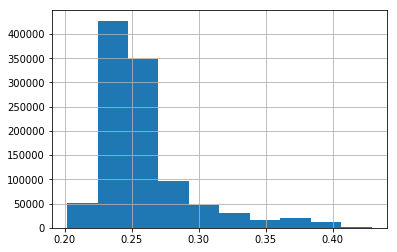

In [63]:
s.hist()

In [47]:
torch.cuda.empty_cache() 

In [284]:
#nope

In [45]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=False)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''

model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
            
        print(images[0].size())
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        print("outputs", outputs[0])
        print("outputs", outputs.size())
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

torch.Size([1, 28, 28])
outputs tensor([-0.0354,  0.0021,  0.0959,  0.0662,  0.1728,  0.0752, -0.0600,
         0.0476,  0.0564,  0.0037], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0369, -0.0064,  0.1112,  0.0533,  0.1395,  0.0700, -0.0920,
         0.1307,  0.0379,  0.0133], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.0767, -0.0077,  0.0508,  0.1065,  0.1026,  0.0628, -0.0717,
         0.2221,  0.0160,  0.0367], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0224,  0.0556,  0.0188,  0.0777,  0.2190,  0.1187, -0.1065,
         0.0858,  0.0145,  0.0339], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0363,  0.0099,  0.0975,  0.0424,  0.1476,  0.0685, -0.0631,
         0.1018,  0.0499, -0.0099], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0461, -0.0076,  0.0435,  0.

         0.0143,  0.0516,  0.0235], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1794, -0.0639,  0.0507,  0.0345,  0.0348, -0.0156,  0.0931,
         0.0110,  0.0361,  0.0540], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.3054, -0.1305,  0.0329,  0.2335, -0.0375, -0.0407,  0.0650,
         0.1272,  0.1139,  0.0428], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0706,  0.1913,  0.0251,  0.0315,  0.0780, -0.0119,  0.0121,
        -0.0067,  0.0431,  0.0853], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1166, -0.0343,  0.2145,  0.1405,  0.0006, -0.0958,  0.0862,
        -0.0074, -0.0192, -0.0109], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1138, -0.0154,  0.1291,  0.0662,  0.1381, -0.0424,  0.1362,
         0.1300,  0.0791,  0.1535], device='cuda:0')
outputs torch.Siz

        -0.0012,  0.0926,  0.0465], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2153, -0.0504,  0.2772,  0.2818, -0.1421,  0.0669,  0.0317,
        -0.0242,  0.1201, -0.0375], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.1481, -0.0290, -0.1409,  0.1086,  0.3453, -0.0198,  0.0365,
         0.2119,  0.1191,  0.3218], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2340, -0.0736,  0.3007, -0.0311,  0.1794, -0.0829,  0.2216,
        -0.1064, -0.0870, -0.0133], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2652, -0.1691,  0.3380,  0.0815,  0.0676, -0.0719,  0.2719,
        -0.0319, -0.0028, -0.0902], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1938, -0.2902,  0.1751,  0.0342,  0.3414, -0.0626,  0.3366,
         0.1982,  0.0506,  0.1300], device='cuda:0')
outputs torch.Siz

         0.7299, -0.5839, -0.0612], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1095, -3.2071, -0.1937,  0.4844,  2.8280,  0.3546,  0.6588,
         1.0491,  0.0116,  2.2217], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-2.4633,  2.5973,  0.9664,  0.6828, -0.7169, -0.5276, -0.2374,
        -0.5142,  1.7331,  0.2319], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.2908, -3.0596, -0.1102, -0.3009,  3.1181,  0.2988,  0.7352,
         1.2592, -0.4123,  1.7364], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 3.9002, -3.3961,  0.2875, -0.4300, -0.4254,  1.2915,  1.3027,
        -0.3025, -0.1085, -0.4615], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 1.1425, -1.2507,  0.6056,  0.1768, -0.0134,  0.8096,  0.7994,
        -0.7930,  0.2489, -0.2901], device='cuda:0')
outputs torch.Siz

         2.0259,  0.7414,  3.2745], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 6.0450, -5.1816,  0.9030, -0.2671, -1.7518,  3.4095,  1.5848,
        -1.8137,  1.1323, -1.6111], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 8.5523, -8.6859,  1.2617,  0.4020, -2.3608,  4.2083,  1.4746,
         0.0452,  0.1328, -0.9304], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-3.2874, -1.5156, -1.7492,  1.5842,  0.8070,  0.4526, -2.3235,
         5.2667,  1.2368,  3.5535], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.1465, -3.0072,  1.7798,  0.3348,  1.8169,  0.1279, -1.1191,
         2.8497,  0.5199,  2.4901], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-1.4875, -3.1280, -0.7397,  2.7330,  0.0189,  1.2328, -2.8664,
         5.9061, -0.0935,  3.1961], device='cuda:0')
outputs torch.Siz

KeyboardInterrupt: 

In [41]:
torch.ones(1, 128, 128)

tensor([[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]])

In [43]:
torch.zeros(1, 128, 128)

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [152]:
dir(train_dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 'download',
 'processed_folder',
 'raw_folder',
 'root',
 'target_transform',
 'test_file',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'urls']

In [157]:
train_dataset.train_labels[9]

tensor(4)

In [165]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(verify_code_loader):
        #print(images.shape, masks)
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 1 == 0 or (iter < 100 and iter % 10 == 0):

            # Print Loss
            print('Iteration: {}. Loss: {}. Mean IU: {}'.format(iter, loss.data.item(), np.mean(t_scores)))

C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration: 1. Loss: 0.6956542730331421. Mean IU: nan
Iteration: 2. Loss: 0.6955004930496216. Mean IU: nan
Iteration: 3. Loss: 0.6953549385070801. Mean IU: nan
Iteration: 4. Loss: 0.6952167749404907. Mean IU: nan
Iteration: 5. Loss: 0.6950857043266296. Mean IU: nan
Iteration: 6. Loss: 0.6949612498283386. Mean IU: nan
Iteration: 7. Loss: 0.6948429346084595. Mean IU: nan
Iteration: 8. Loss: 0.694730281829834. Mean IU: nan
Iteration: 9. Loss: 0.6946234107017517. Mean IU: nan
Iteration: 10. Loss: 0.6945216655731201. Mean IU: nan
Iteration: 11. Loss: 0.6944248676300049. Mean IU: nan
Iteration: 12. Loss: 0.6943326592445374. Mean IU: nan
Iteration: 13. Loss: 0.6942448616027832. Mean IU: nan
Iteration: 14. Loss: 0.694161057472229. Mean IU: nan
Iteration: 15. Loss: 0.6940809488296509. Mean IU: nan
Iteration: 16. Loss: 0.6940043568611145. Mean IU: nan
Iteration: 17. Loss: 0.6939314007759094. Mean IU: nan
Iteration: 18. Loss: 0.693861722946167. Mean IU: nan
Iteration: 19. Loss: 0.6937956213951111.

KeyboardInterrupt: 

In [172]:
salt_ID_dataset_test_code = saltIDDataset(X_verify_code, 
                                      train=True, 
                                      preprocessed_masks=Y_verify_code)

batch_size = 50
n_iters = 10
num_epochs = n_iters / (len(X_verify_code) / batch_size)
num_epochs = int(num_epochs)

verify_code_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test_code, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [132]:
rand_test = torch.rand(1, 128, 128)
print(rand_test)
rand_test.unsqueeze(-1)
X_verify_code = rand_test.expand(4000, 1, 128, 128)

tensor([[[ 0.5341,  0.8455,  0.7615,  ...,  0.9390,  0.6946,  0.5961],
         [ 0.7768,  0.1688,  0.4930,  ...,  0.5080,  0.8612,  0.0909],
         [ 0.0967,  0.6116,  0.2333,  ...,  0.6345,  0.8658,  0.6177],
         ...,
         [ 0.4411,  0.8837,  0.4665,  ...,  0.5634,  0.9038,  0.5196],
         [ 0.5572,  0.3379,  0.0018,  ...,  0.6096,  0.6634,  0.9831],
         [ 0.2588,  0.8478,  0.1653,  ...,  0.5666,  0.2297,  0.6487]]])


In [134]:
verify_ones = torch.ones(4000, 1, 128, 128)
verify_zeros = torch.zeros(4000, 1, 128, 128)

In [135]:
Y_verify_code = torch.where(X_verify_code > .5, verify_ones, verify_zeros)

In [140]:
Y_verify_code.shape

torch.Size([4000, 1, 128, 128])